# NYC Yellow Taxis ML Model 

In [13]:
import warnings
warnings.filterwarnings("ignore")

import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [2]:
# Build a SparkSession instance if one does not exist. Notice that we can only have one per JVM

spark = SparkSession\
    .builder\
    .appName("taxi_ny")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [3]:
df_preprocessed = spark.read.csv("yellow_data_final.csv", header="true", inferSchema="true", sep=',')

In [4]:
df_preprocessed=df_preprocessed[["passenger_count","trip_distance","tip","tip_amount","total_amount","duration"]]

In [5]:
feature_list = []
for col in df_preprocessed.columns:
    if col == 'total_amount':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")


In [6]:
rf = RandomForestRegressor(labelCol="total_amount", featuresCol="features")

In [7]:
pipeline = Pipeline(stages=[assembler, rf])

In [8]:
(trainingData, testData) = df_preprocessed.randomSplit([0.8, 0.2])

In [9]:
model = pipeline.fit(trainingData)

In [10]:
predictions = model.transform(testData)

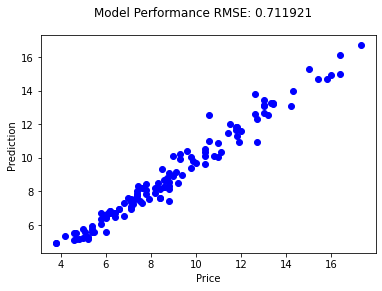

In [14]:
import matplotlib.pyplot as plt
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = model.transform(df_preprocessed)
rfResult = rfPred.toPandas()
plt.plot(rfResult.total_amount, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

## Binary Classification for tip or no tip

In [15]:
df_preprocessed_BC=df_preprocessed[["passenger_count","trip_distance","tip","total_amount","duration"]]

In [16]:
feature_list = []
for col in df_preprocessed_BC.columns:
    if col == 'tip':
        continue
    
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")


In [17]:
rc = RandomForestClassifier(labelCol="tip", featuresCol="features")

In [18]:
pipeline = Pipeline(stages=[assembler, rc])

In [19]:
(trainingData, testData) = df_preprocessed_BC.randomSplit([0.8, 0.2])

In [20]:
model = pipeline.fit(trainingData)

In [21]:
predictions = model.transform(testData)

In [22]:
predictions.select("passenger_count","trip_distance","total_amount","duration","tip", "prediction").show(10)

+---------------+-------------+------------+--------+---+----------+
|passenger_count|trip_distance|total_amount|duration|tip|prediction|
+---------------+-------------+------------+--------+---+----------+
|              1|         0.28|         4.7|     4.0|  0|       0.0|
|              1|          0.5|         5.8|     8.0|  0|       0.0|
|              1|          0.6|         4.6|     4.0|  0|       0.0|
|              1|         0.67|         5.4|     5.0|  0|       0.0|
|              1|          0.8|         4.2|     1.0|  0|       0.0|
|              1|         0.92|         6.0|     4.0|  0|       0.0|
|              1|         0.92|         6.2|     8.0|  0|       0.0|
|              1|          1.0|        8.51|    11.0|  1|       0.0|
|              1|          1.1|         8.2|    11.0|  0|       0.0|
|              1|          1.1|         7.4|     4.0|  1|       1.0|
+---------------+-------------+------------+--------+---+----------+
only showing top 10 rows



In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="tip", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8316026375014807
Test Error = 0.16839736249851933
